In [1]:
import os
from os.path import isfile, isdir, join
import logging

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily
import itertools

import crime_patterns.utilities as utils

%load_ext autoreload
%autoreload 2

In [2]:
logger = logging.getLogger(__name__)
# logger.setLevel(logging.INFO)

In [52]:
data_dir = r"..\crime_patterns\data"
shapefiles_dir = os.path.join(data_dir, "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_LSOA_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")

crime_incidence_path = os.path.join(data_dir, r"uk_crime_data_all\2021-01\2021-01-city-of-london-street.csv")
mps_lsoa_crime_path = os.path.join(data_dir, r"MPS_LSOA_Level_Crime\MPS LSOA Level Crime (Historical).csv")
cleaned_data_dir = r"C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\bld\python\data"

In [53]:
london_lsoa = gpd.read_file(london_LSOA_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)

In [54]:
london_lsoa.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [7]:
## Load and clean burglary data
## load
mps_lsoa_crime = pd.read_csv(mps_lsoa_crime_path)

crime_major_categories = mps_lsoa_crime["Major Category"].unique()

## Select crime category
mps_lsoa_burglary = mps_lsoa_crime.query("`Major Category` == 'Burglary'")

## Select year
year_columns = mps_lsoa_burglary.filter(regex='2019').columns
columns_to_keep = ['LSOA Code', 'LSOA Name', 'Borough', 'Major Category', 'Minor Category'] + list(year_columns)
mps_lsoa_burglary_2019 = mps_lsoa_burglary[columns_to_keep]

## Aggregate data per LSOA and create gdf
mps_lsoa_burglary_2019 = mps_lsoa_burglary_2019.groupby(by="LSOA Code").sum()
mps_lsoa_burglary_2019_gdf = london_lsoa.merge(mps_lsoa_burglary_2019, left_on="LSOA11CD", right_on="LSOA Code", how="outer")

## Sum crime for whole year
mps_lsoa_burglary_2019_gdf = mps_lsoa_burglary_2019_gdf.fillna(0)
mps_lsoa_burglary_2019_gdf["2019"] = mps_lsoa_burglary_2019_gdf[year_columns].sum(1)

## Save to disk
mps_lsoa_burglary_2019_gdf.to_file(join(cleaned_data_dir, "MPS_LSOA_Level_burglary_2019.shp"))


In [ ]:
fig, axes = london_ward.plot(color="lavender", edgecolor="black", linewidth= 0.3, alpha=0.8)

# contextily.add_basemap(
#     axes,
#     crs=london_ward.crs,
#     source=contextily.providers.CartoDB.PositronNoLabels,
# )

In [39]:
london_ward.crs

<Derived Projected CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [24]:
# london_ward_4326 = london_ward.to_crs(4326)
crime_data_gdf_BritishGrid = crime_data_gdf.to_crs(london_ward.crs)

<Axes: >

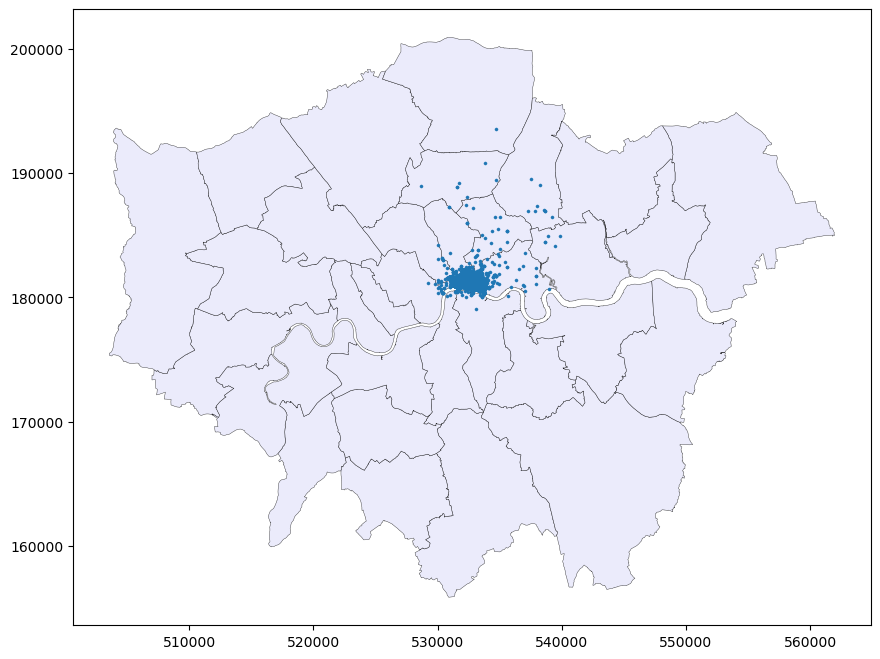

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

london_borough.plot(ax=ax, color="lavender", edgecolor="black", linewidth= 0.3, alpha=0.8)

crime_data_gdf_BritishGrid.plot(ax=ax, 
                    # color="red",
                    # cmap="Spectral",
                    # column='Crime type',
                    # colorbar=True,
                    markersize=5, 
                    # edgecolor="k", 
                    legend=True,
                    legend_kwds={'bbox_to_anchor': (0.5, 0.8)},
                    linewidth=0.3,
                    aspect=1
                    )

# ax.set_xlim(-0.150, -0.02)
# ax.set_ylim(51.49, 51.56)
# ax.legend()

In [39]:
crime_incidence_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
crime_incidence_gdf['Crime type'].unique()

array(['Anti-social behaviour', 'Other theft', 'Shoplifting',
       'Theft from the person', 'Criminal damage and arson', 'Drugs',
       'Public order', 'Violence and sexual offences', 'Bicycle theft',
       'Burglary', 'Vehicle crime', 'Robbery', 'Other crime',
       'Possession of weapons'], dtype=object)

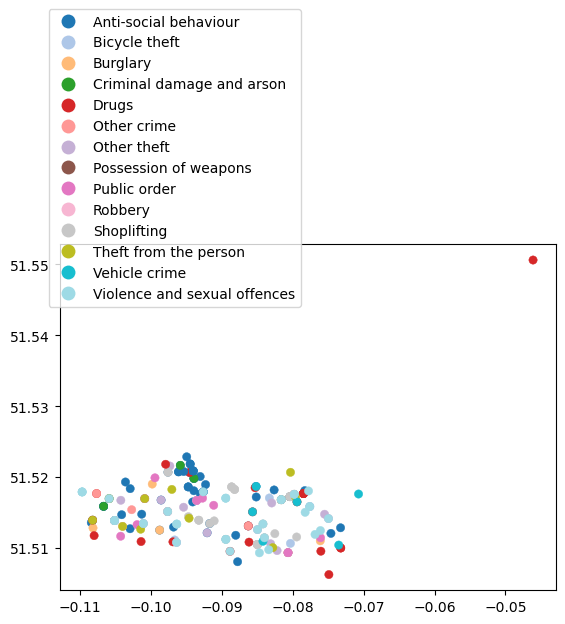

In [82]:
ax = crime_incidence_gdf.plot(# ax=ax, 
                        # color="red",
                        cmap="tab20",
                        column='Crime type',
                        # colorbar=True,
                        # markersize=2, 
                        # edgecolor="k", 
                        legend=True,
                        legend_kwds={'bbox_to_anchor': (0.5, 0.8)},
                        linewidth=0.3,
                        aspect=1
                        )
                        
